In [35]:
import numpy as np
import pprint as pp
from matplotlib import pyplot as plt
import shutil
import os
import copy
from IPython.display import clear_output

In [36]:
FILENAME = 'kroB200.tsp'

In [37]:

def read_data_file(file_name):
    tsp_data = {}
    with open(FILENAME, 'r') as file:
        for line in file:
            if line.startswith('EOF'):
                break
            if line.startswith('DIMENSION'):
                tsp_data['DIMENSION'] = int(line.split()[1])
            parts = line.split()
            if parts[0].isdigit():
                node, x, y = map(int, parts)
                tsp_data[node] = (x, y)

    return tsp_data

def calculate_distance_matrix(tsp_data):
    N = tsp_data['DIMENSION']
    tsp_data.pop('DIMENSION')

    distance_matrix = [[0 for _ in range(N + 1)] for _ in range(N + 1)]
    for node in tsp_data:
        x1, y1 = tsp_data[node]
        for other_node in tsp_data:
            if node == other_node:
                continue
            else:
                x2, y2 = tsp_data[other_node]
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                distance = round(distance, 2)
                distance_matrix[node][other_node] = distance
                distance_matrix[other_node][node] = distance
    return np.array(distance_matrix)

def print_distance_matrix(distance_matrix):
    # for row in distance_matrix:
    #     print(row)
    print(distance_matrix)

In [38]:
data = read_data_file('kroA100.tsp')
distance = calculate_distance_matrix(data)
print_distance_matrix(distance)

[[   0.      0.      0.   ...    0.      0.      0.  ]
 [   0.      0.   2606.93 ... 1239.76 1231.55 3117.49]
 [   0.   2606.93    0.   ... 3442.17 1643.61  933.36]
 ...
 [   0.   1239.76 3442.17 ...    0.   2398.07 3679.76]
 [   0.   1231.55 1643.61 ... 2398.07    0.   2406.37]
 [   0.   3117.49  933.36 ... 3679.76 2406.37    0.  ]]


In [39]:
def plot_cities(data):
    x = []
    y = []
    for city in data:
        x.append(data[city][0])
        y.append(data[city][1])
    plt.scatter(x, y)
    plt.show()

def plot_cycles(cycle1, cycle2, tsp_data):
    x = []
    y = []
    for city in cycle1:
        x.append(tsp_data[city][0])
        y.append(tsp_data[city][1])
    x.append(tsp_data[cycle1[0]][0])
    y.append(tsp_data[cycle1[0]][1])
    plt.plot(x, y, 'ro-')

    x = []
    y = []
    for city in cycle2:
        x.append(tsp_data[city][0])
        y.append(tsp_data[city][1])
    x.append(tsp_data[cycle2[0]][0])
    y.append(tsp_data[cycle2[0]][1])
    plt.plot(x, y, 'bo-')

    plt.show()

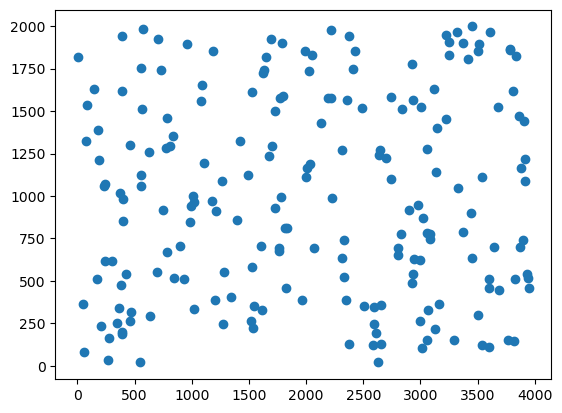

In [40]:
plot_cities(data)

In [41]:
def get_nodes(tsp_data):
    nodes = []
    for node in tsp_data:
        if node != 'DIMENSION':
            nodes.append(node)
    return np.array(nodes)

In [42]:
get_nodes(data)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [43]:
def random_cycle(nodes):
    nodes = copy.deepcopy(nodes)
    np.random.shuffle(nodes)
    half = len(nodes) // 2
    cycle1 = np.array(nodes[:half])
    cycle2 = np.array(nodes[half:])
    
    return cycle1, cycle2

In [44]:
def swap_nodes_between_cycles(cycle1, cycle2, a_index, b_index):
    cycle1 = copy.deepcopy(cycle1)
    cycle2 = copy.deepcopy(cycle2)

    tmp = cycle2[b_index]
    cycle2[b_index] = cycle1[a_index]
    cycle1[a_index] = tmp

    return cycle1, cycle2


def swap_edge_within_cycle(cycle, a_index, b_index):
    cycle = copy.deepcopy(cycle)
    
    b_index = (b_index + 1) % (len(cycle) + 1)
    if a_index > b_index:
        a_index, b_index = b_index, a_index
    cycle[a_index:b_index] = cycle[a_index:b_index][::-1]
    return cycle

In [45]:
SWAP_NODES_BETWEEN = 0
SWAP_EDGES_WITHIN_CYCLE_1 = 1
SWAP_EDGES_WITHIN_CYCLE_2 = 2

def generate_moves(cycle):

    moves = []
    N = len(cycle)

    # generate edges
    for i in range(2, N-1):
        for j in range(N):
            k = (j + i) % (N)
            if j < k:
                moves.append((SWAP_EDGES_WITHIN_CYCLE_1, (j, k)))


    # generate edges
    for i in range(2, N-1):
        for j in range(N):
            k = (j + i) % (N)
            if j < k:
                moves.append((SWAP_EDGES_WITHIN_CYCLE_2, (j, k)))

    # generate nodes
    for i in range(N):
        for j in range(N):
                moves.append((SWAP_NODES_BETWEEN, (i, j)))
    
    # shuffle moves
    #np.random.shuffle(moves)
    return moves

In [46]:

def apply_move(move, cycle1, cycle2):
    move_type, (a, b) = move
    
    if move_type == SWAP_NODES_BETWEEN:
        cycle1, cycle2 = swap_nodes_between_cycles(cycle1, cycle2, a, b)

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_1:
        cycle1 = swap_edge_within_cycle(cycle1, a, b)

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_2:
        cycle2 = swap_edge_within_cycle(cycle2, a, b)

    return cycle1, cycle2

In [47]:
cycle2 = [7, 8, 9, 10, 11, 12]
cycle = [1, 2, 3, 4, 5, 6]
moves = generate_moves(cycle)

print(cycle, cycle2)
for move in moves:
    cycle, cycle2 = apply_move(move, cycle, cycle2)
    print(move, cycle, cycle2)


[1, 2, 3, 4, 5, 6] [7, 8, 9, 10, 11, 12]
(1, (0, 2)) [3, 2, 1, 4, 5, 6] [7, 8, 9, 10, 11, 12]
(1, (1, 3)) [3, 4, 1, 2, 5, 6] [7, 8, 9, 10, 11, 12]
(1, (2, 4)) [3, 4, 5, 2, 1, 6] [7, 8, 9, 10, 11, 12]
(1, (3, 5)) [3, 4, 5, 6, 1, 2] [7, 8, 9, 10, 11, 12]
(1, (0, 3)) [6, 5, 4, 3, 1, 2] [7, 8, 9, 10, 11, 12]
(1, (1, 4)) [6, 1, 3, 4, 5, 2] [7, 8, 9, 10, 11, 12]
(1, (2, 5)) [6, 1, 2, 5, 4, 3] [7, 8, 9, 10, 11, 12]
(1, (0, 4)) [4, 5, 2, 1, 6, 3] [7, 8, 9, 10, 11, 12]
(1, (1, 5)) [4, 3, 6, 1, 2, 5] [7, 8, 9, 10, 11, 12]
(2, (0, 2)) [4, 3, 6, 1, 2, 5] [9, 8, 7, 10, 11, 12]
(2, (1, 3)) [4, 3, 6, 1, 2, 5] [9, 10, 7, 8, 11, 12]
(2, (2, 4)) [4, 3, 6, 1, 2, 5] [9, 10, 11, 8, 7, 12]
(2, (3, 5)) [4, 3, 6, 1, 2, 5] [9, 10, 11, 12, 7, 8]
(2, (0, 3)) [4, 3, 6, 1, 2, 5] [12, 11, 10, 9, 7, 8]
(2, (1, 4)) [4, 3, 6, 1, 2, 5] [12, 7, 9, 10, 11, 8]
(2, (2, 5)) [4, 3, 6, 1, 2, 5] [12, 7, 8, 11, 10, 9]
(2, (0, 4)) [4, 3, 6, 1, 2, 5] [10, 11, 8, 7, 12, 9]
(2, (1, 5)) [4, 3, 6, 1, 2, 5] [10, 9, 12, 7, 8, 11]
(0, (

In [48]:
def calculate_cycles_length(cycle1, cycle2, distance_matrix):
    c = [cycle1, cycle2]
    total_length = 0
    for cycle in c:
        length = 0
        for i in range(len(cycle)):
            length += distance_matrix[cycle[i-1]][cycle[i]]
        total_length += length

    return total_length

In [49]:
def local_search_greedy(cycle1, cycle2, distance):

    cycle1 = copy.deepcopy(cycle1)
    cycle2 = copy.deepcopy(cycle2)

    moves = generate_moves(cycle1)


    iter = 0
    while True:

        best_move = None
        best_delta = 0
  
        iter += 1

        for move in moves:

            subdistance_before = 0
            subdistance_after = 0

            move_type, (A, B) = move

            if move_type == SWAP_NODES_BETWEEN:
                a = cycle1[A]
                b = cycle2[B]

                a_prev = cycle1[(A-1) % len(cycle1)]
                a_next = cycle1[(A+1) % len(cycle1)]

                b_prev = cycle2[(B-1) % len(cycle2)]
                b_next = cycle2[(B+1) % len(cycle2)]

                subdistance_before += distance[a_prev][a] + distance[a][a_next] + distance[b_prev][b] + distance[b][b_next]
                subdistance_after += distance[a_prev][b] + distance[b][a_next] + distance[b_prev][a] + distance[a][b_next]

            elif move_type == SWAP_EDGES_WITHIN_CYCLE_1:
                a = cycle1[A]
                b = cycle1[B]

                a_prev = cycle1[(A-1) % len(cycle1)]
                b_next = cycle1[(B+1) % len(cycle1)]

                subdistance_before += distance[a_prev][a] + distance[b][b_next]
                subdistance_after += distance[a_prev][b] + distance[a][b_next]

            elif move_type == SWAP_EDGES_WITHIN_CYCLE_2:

                a = cycle2[A]
                b = cycle2[B]

                a_prev = cycle2[(A-1) % len(cycle2)]
                b_next = cycle2[(B+1) % len(cycle2)]

                subdistance_before += distance[a_prev][a] + distance[b][b_next]
                subdistance_after += distance[a_prev][b] + distance[a][b_next]


            delta = subdistance_after - subdistance_before

            if delta < best_delta:
                best_move = move
                best_delta = delta
                

        if best_delta < 0:
            # print("Stosuję ruch: ", best_move)
            cycle1, cycle2 = apply_move(best_move, cycle1, cycle2)
            if iter % 5 == 0:
                clear_output(wait=True)
                plot_cycles(cycle1, cycle2, data)
        elif best_move is None:
            break

    return cycle1, cycle2


323687.0


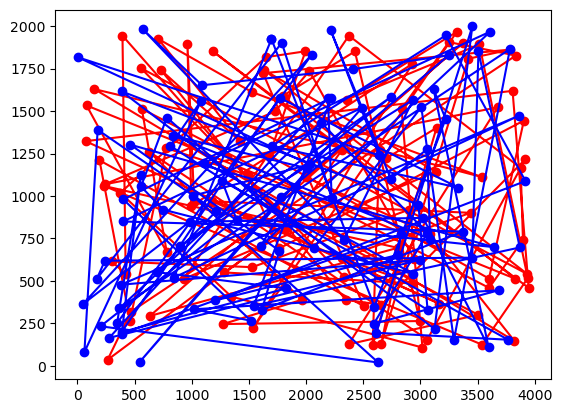

In [50]:
random_cycle1, random_cycle2 = random_cycle(get_nodes(data))

print(calculate_cycles_length(random_cycle1, random_cycle2, distance))
plot_cycles(random_cycle1, random_cycle2, data)

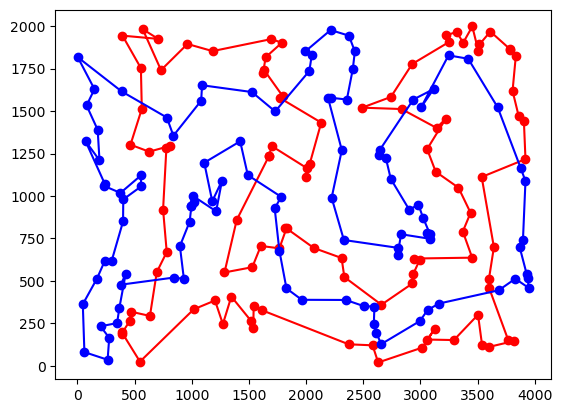

38489.04

In [51]:
# cycle1, cycle2 = local_search_greedy(random_cycle1, random_cycle2, distance)
# calculate_cycles_length(cycle1, cycle2, distance)

In [52]:
def compute_k_closest_neighbours(distance, k):
    dist = distance[1:, 1:]
    closest = np.argpartition(dist, k+1, axis=1)[:, :k+1] + 1
    zeros = np.zeros(len(closest[0]), dtype=np.uint16)
    return np.concatenate(([zeros], closest))

In [53]:
def find_city(cycle1, cycle2, node):
    
    out = np.where(cycle1 == node)[0]

    if len(out) == 1:
        return (True, out[0])
    else:
        return (False, np.where(cycle2 == node)[0][0])

In [54]:
def candidate_moves_algorithm(cycle1, cycle2, distance, k, data):
    closest = compute_k_closest_neighbours(distance, k)
    num_cities = len(get_nodes(data))
    iter = 0

    while True:
        best_move = None
        best_delta = 0

        for i in range(1, num_cities+1):
            for j in closest[i]:
                if i==j:
                    continue
                i_in_cycle1, pos_i = find_city(cycle1, cycle2, i)
                j_in_cycle1, pos_j = find_city(cycle1, cycle2, j)

                if (i_in_cycle1 and j_in_cycle1):
                    pos_i_succ = (pos_i+1)%len(cycle1)
                    pos_j_succ = (pos_j+1)%len(cycle1)

                    pos_i_pred = (pos_i-1)%len(cycle1)
                    pos_j_pred = (pos_j-1)%len(cycle1)

                    distance_before_succ = distance[i][cycle1[pos_i_succ]] + distance[j][cycle1[pos_j_succ]] # wariant 1
                    distance_after_succ = distance[i][j] + distance[cycle1[pos_i_succ]][cycle1[pos_j_succ]]

                    distance_before_pred = distance[i][cycle1[pos_i_pred]] + distance[j][cycle1[pos_j_pred]] # wariant 2
                    distance_after_pred = distance[i][j] + distance[cycle1[pos_i_pred]][cycle1[pos_j_pred]]

                elif (i_in_cycle1 is False and j_in_cycle1 is False):
                    pos_i_succ = (pos_i+1)%len(cycle2)
                    pos_j_succ = (pos_j+1)%len(cycle2)

                    pos_i_pred = (pos_i-1)%len(cycle2)
                    pos_j_pred = (pos_j-1)%len(cycle2)

                    distance_before_succ = distance[i][cycle2[pos_i_succ]] + distance[j][cycle2[pos_j_succ]]
                    distance_after_succ = distance[i][j] + distance[cycle2[pos_i_succ]][cycle2[pos_j_succ]]

                    distance_before_pred = distance[i][cycle2[pos_i_pred]] + distance[j][cycle2[pos_j_pred]]
                    distance_after_pred = distance[i][j] + distance[cycle2[pos_i_pred]][cycle2[pos_j_pred]]
                delta_succ = distance_after_succ - distance_before_succ
                delta_pred = distance_after_pred - distance_before_pred
                delta = min(delta_pred, delta_succ)
                which_delta = np.argmin([delta_succ, delta_pred])

                if best_delta > delta:
                    best_delta = delta
                    
                    if (i_in_cycle1 and j_in_cycle1):
                        if which_delta == 0:
                            best_move = (SWAP_EDGES_WITHIN_CYCLE_1, (pos_i_succ, pos_j))
                        elif which_delta == 1:
                            best_move = (SWAP_EDGES_WITHIN_CYCLE_1, (pos_i, pos_j_pred))
                    elif (i_in_cycle1 is False and j_in_cycle1 is False):
                        if which_delta == 0:
                            best_move = (SWAP_EDGES_WITHIN_CYCLE_2, (pos_i_succ, pos_j))
                        elif which_delta == 1:
                            best_move = (SWAP_EDGES_WITHIN_CYCLE_2, (pos_i, pos_j_pred))

        
        if best_move is None:
            break

        cycle1, cycle2 = apply_move(best_move, cycle1, cycle2)
        if iter % 5:
            clear_output(wait=True)
            plot_cycles(cycle1, cycle2, data)
        iter += 1
    
    return (cycle1, cycle2)

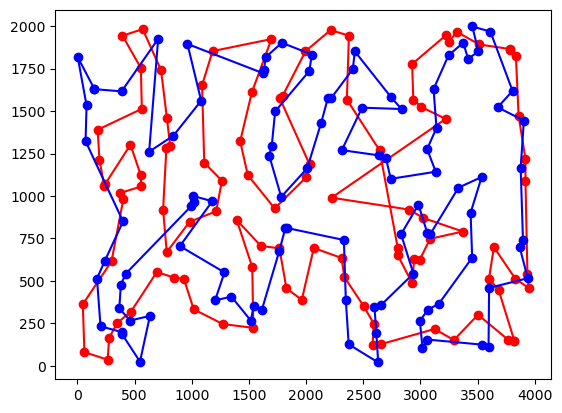

47051.35

In [58]:
cycle1, cycle2 = random_cycle(get_nodes(data))

k = candidate_moves_algorithm(cycle1, cycle2, distance, 10, data)

calculate_cycles_length(k[0], k[1], distance)